# EDA AND PREPROCESSING

In [76]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
import warnings
from tqdm import tqdm
warnings.filterwarnings( 'ignore' )

import matplotlib.pyplot as plt
import os 
import sys
import time
import seaborn as sns
import math

In [3]:
path = '/home/yejun4548/smartfactory/data'
file_list = os.listdir(path)
print(file_list)

['train_2nd_Looseness.csv', 'train_3rd_Normal.csv', 'train_1st_Normal.csv', 'train_1st_Unbalance.csv', 'train_1st_Looseness.csv', 'train_2nd_Bearing.csv', 'train_1st_high.csv', 'train_3rd_Unbalance.csv', 'train_1st_Bearing.csv', 'train_2nd_Unbalance.csv']


In [7]:
def Dataset_Constructor(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):

  #Normal[label 0] → Fault-free operating condition
  #Unbalance[label 1] → Unbalance between centers of mass and axis
  #Belt-Looseness[label 2] → Looseness of V‐belt connecting between motor pully and screw pully
  #Belt-Looseness High[label 3] → High Looseness of V-belt
  #Bearing fault[label 4] → Removing grease of Ball Bearing on Motor, which induces its wear-out

  Number_of_data = int(df.shape[0]/(time_series_length -( 128 - window )))-128
  data_array = np.zeros((Number_of_data, time_series_length, NumofChannel))
  label = np.full_like(np.zeros((Number_of_data)), label)
  for i in tqdm(range(Number_of_data)):
    data_array[i]= df.iloc[window*(i) : window*i+128,: ].values
  ds = tf.data.Dataset.from_tensor_slices((data_array ,label))
  return ds

def TEST_Dataset_Constructor(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):
  Number_of_data = int(df.shape[0]/(time_series_length -( 128 - window )))
  data_array = np.zeros((Number_of_data, time_series_length, NumofChannel))
  label = np.full_like(np.zeros((Number_of_data)), label)
  for i in range(Number_of_data):
    data_array[i]= df.iloc[window*(i) : window*i+128,: ].values
  ds = tf.data.Dataset.from_tensor_slices((data_array ,label))
  return  ds


### DATA Loading

In [18]:
sub = pd.read_csv('/home/yejun4548/smartfactory/sample_submission_classification.csv')
final = pd.read_csv('/home/yejun4548/smartfactory/final.csv').iloc[:,1:]
test_Dataset = TEST_Dataset_Constructor(final)

In [22]:
file_list[9]

'train_2nd_Unbalance.csv'

In [23]:
train_1st_Bearing = pd.read_csv(os.path.join(path, file_list[8]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Looseness = pd.read_csv(os.path.join(path, file_list[4]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Normal = pd.read_csv(os.path.join(path, file_list[2]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Unbalance = pd.read_csv(os.path.join(path, file_list[3]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_high = pd.read_csv(os.path.join(path, file_list[6]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Bearing = pd.read_csv(os.path.join(path, file_list[5]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Looseness = pd.read_csv(os.path.join(path, file_list[0]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Unbalance = pd.read_csv(os.path.join(path, file_list[9]),float_precision = 'round_trip').iloc[:, 1:]
train_3rd_Normal = pd.read_csv(os.path.join(path, file_list[1]),float_precision = 'round_trip').iloc[:, 1:]
train_3rd_Unbalance = pd.read_csv(os.path.join(path, file_list[7]),float_precision = 'round_trip').iloc[:, 1:]

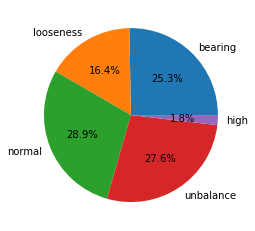

In [24]:
bearing = train_1st_Bearing.shape[0]+train_2nd_Bearing.shape[0]
looseness = train_1st_Looseness.shape[0]+train_2nd_Looseness.shape[0]
normal = train_1st_Normal.shape[0] + train_3rd_Normal.shape[0]
unbalance = train_1st_Unbalance.shape[0] + train_2nd_Unbalance.shape[0] + train_3rd_Unbalance.shape[0]
high = train_1st_high.shape[0] 

plt.pie([bearing,looseness,normal,unbalance,high], labels=['bearing','looseness','normal','unbalance','high'], autopct='%.1f%%')
plt.show()

### Dataset Construction/Augmentation and Solving Class Imabalance Problem

In [25]:
Bearing1st_ds = Dataset_Constructor(train_1st_Bearing, label = 4 )
Looseness1st_ds = Dataset_Constructor(train_1st_Looseness,label = 2,window = 90)
Normal1st_ds = Dataset_Constructor(train_1st_Normal, label = 0 )
Unbalance1st_ds = Dataset_Constructor(train_1st_Unbalance, label = 1)
High1st_ds = Dataset_Constructor(train_1st_high, label = 3, window = 9)

100%|██████████| 487004/487004 [00:38<00:00, 12708.28it/s]


In [26]:
Bearing2nd_ds = Dataset_Constructor(train_2nd_Bearing, label = 4 )
Looseness2nd_ds = Dataset_Constructor(train_2nd_Looseness,label = 2,window = 90)
Unbalance2nd_ds = Dataset_Constructor(train_2nd_Unbalance, label = 1)
Normal3rd_ds = Dataset_Constructor(train_3rd_Normal, label = 0)
Unbalance3rd_ds = Dataset_Constructor(train_3rd_Unbalance, label = 1)

100%|██████████| 184375/184375 [00:14<00:00, 12371.32it/s]


In [27]:
bearing = Bearing1st_ds.__len__().numpy() + Bearing2nd_ds.__len__().numpy()
looseness = Looseness1st_ds.__len__().numpy() + Looseness2nd_ds.__len__().numpy()
normal = Normal1st_ds.__len__().numpy() + Normal3rd_ds.__len__().numpy()
unbalance = Unbalance1st_ds.__len__().numpy() + Unbalance2nd_ds.__len__().numpy() + Unbalance3rd_ds.__len__().numpy()
high = High1st_ds.__len__().numpy()

plt.pie([bearing,looseness,normal,unbalance,high], labels=['bearing','looseness','normal','unbalance','high'], autopct='%.1f%%')
plt.show()

AttributeError: 'TensorSliceDataset' object has no attribute '__len__'

In [56]:
Dataset = Bearing1st_ds.concatenate(Looseness1st_ds).concatenate(Normal1st_ds).concatenate(Unbalance1st_ds).concatenate(High1st_ds).concatenate(Bearing2nd_ds).concatenate(Looseness2nd_ds).concatenate(Unbalance2nd_ds).concatenate(Normal3rd_ds).concatenate(Unbalance3rd_ds).shuffle(buffer_size = 4518720, seed = 42).batch(128).prefetch(1)

In [57]:
Valid_Dataset = Dataset.take(3000) 
Train_Dataset = Dataset.skip(3000)

# VISUALIZATION

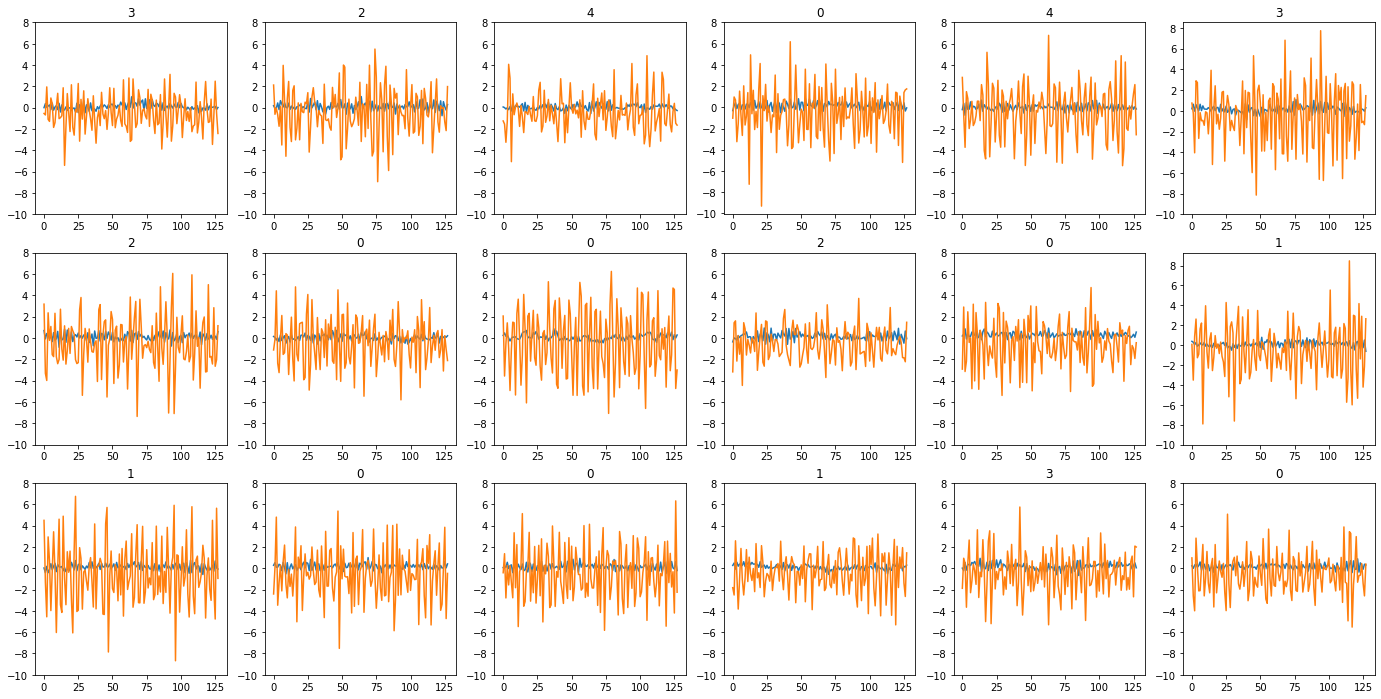

In [30]:
rows = 3
cols = 6
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(24, 12))
for i, (audio, label) in enumerate(Dataset.unbatch().take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-10, 10, 2))
  label = int(label.numpy())#.decode('utf-8')
  ax.set_title(label)

#Fast Fourier Transform and Continuous Wavelet Transform

In [31]:
Sample = list(Train_Dataset.unbatch().take(1).as_numpy_iterator())[0][0]

https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.fft.html

https://pywavelets.readthedocs.io/en/latest/ref/cwt.html

In [32]:
import  pywt
from scipy import fftpack

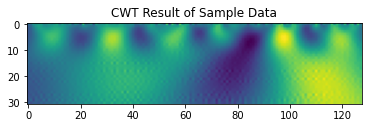

In [33]:
coef, freqs = pywt.cwt(Sample ,np.arange(1,32), 'gaus1' , axis = 0)
plt.imshow(coef[:,:,0])
plt.title("CWT Result of Sample Data")
plt.show()

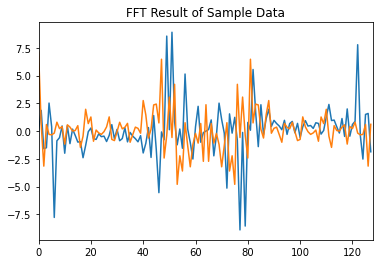

In [34]:
imag = fftpack.fft(Sample[:,0]).imag
real = fftpack.fft(Sample[:,0]).real
plt.plot(imag)
plt.plot(real)
plt.xlim((0,128))
plt.title("FFT Result of Sample Data")
plt.show()

#CUSTOM MODELING

In [70]:
def conv(layer):
    layer = keras.layers.Conv1D(filters=4, kernel_size = 8, strides=2, padding='same')(layer)
    layer = keras.layers.BatchNormalization()(layer)
    layer = keras.layers.MaxPool1D(pool_size = 2, padding='same')(layer)
    layer = keras.layers.Activation('relu')(layer)
    return layer

In [88]:
def lstm(layer):
    layer = keras.layers.LSTM(64, recurrent_dropout = 0.2, dropout = 0.2, return_sequences = True)(layer)
    return layer

In [80]:
def output_layer(layer):
    layer = keras.layers.Dense(32)(layer)
    layer = keras.layers.Dense(5, activation = 'softmax')(layer)
    return layer

In [90]:
inputs = keras.layers.Input(shape = (128, 2), dtype='float32', name='inputs')
layer = conv(inputs)
layer = conv(layer)
layer = lstm(layer)
layer = keras.layers.Flatten()(layer)
output = output_layer(layer)
model = keras.models.Model(inputs=[inputs], outputs=[output])
model.summary()

from sklearn.metrics import f1_score 
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001, clipnorm=1), metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), f1_score])

model.fit(Train_Dataset, epochs = 3,batch_size = 256, shuffle = True, validation_data = Valid_Dataset)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 128, 2)]          0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 64, 4)             68        
_________________________________________________________________
batch_normalization_36 (Batc (None, 64, 4)             16        
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 32, 4)             0         
_________________________________________________________________
activation_24 (Activation)   (None, 32, 4)             0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 16, 4)             132       
_________________________________________________________________
batch_normalization_37 (Batc (None, 16, 4)             16  

TypeError: in user code:

    /home/yejun4548/anaconda3/envs/HCM/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /home/yejun4548/anaconda3/envs/HCM/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/yejun4548/anaconda3/envs/HCM/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/yejun4548/anaconda3/envs/HCM/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/yejun4548/anaconda3/envs/HCM/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:543 train_step  **
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    /home/yejun4548/anaconda3/envs/HCM/lib/python3.6/site-packages/tensorflow/python/keras/engine/compile_utils.py:411 update_state
        metric_obj.update_state(y_t, y_p)
    /home/yejun4548/anaconda3/envs/HCM/lib/python3.6/site-packages/tensorflow/python/keras/utils/metrics_utils.py:90 decorated
        update_op = update_state_fn(*args, **kwargs)
    /home/yejun4548/anaconda3/envs/HCM/lib/python3.6/site-packages/tensorflow/python/keras/metrics.py:603 update_state
        matches = self._fn(y_true, y_pred, **self._fn_kwargs)
    /home/yejun4548/anaconda3/envs/HCM/lib/python3.6/site-packages/sklearn/utils/validation.py:63 inner_f
        return f(*args, **kwargs)
    /home/yejun4548/anaconda3/envs/HCM/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1074 f1_score
        zero_division=zero_division)
    /home/yejun4548/anaconda3/envs/HCM/lib/python3.6/site-packages/sklearn/utils/validation.py:63 inner_f
        return f(*args, **kwargs)
    /home/yejun4548/anaconda3/envs/HCM/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1202 fbeta_score
        zero_division=zero_division)
    /home/yejun4548/anaconda3/envs/HCM/lib/python3.6/site-packages/sklearn/utils/validation.py:63 inner_f
        return f(*args, **kwargs)
    /home/yejun4548/anaconda3/envs/HCM/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465 precision_recall_fscore_support
        pos_label)
    /home/yejun4548/anaconda3/envs/HCM/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1277 _check_set_wise_labels
        y_type, y_true, y_pred = _check_targets(y_true, y_pred)
    /home/yejun4548/anaconda3/envs/HCM/lib/python3.6/site-packages/sklearn/metrics/_classification.py:83 _check_targets
        check_consistent_length(y_true, y_pred)
    /home/yejun4548/anaconda3/envs/HCM/lib/python3.6/site-packages/sklearn/utils/validation.py:316 check_consistent_length
        lengths = [_num_samples(X) for X in arrays if X is not None]
    /home/yejun4548/anaconda3/envs/HCM/lib/python3.6/site-packages/sklearn/utils/validation.py:316 <listcomp>
        lengths = [_num_samples(X) for X in arrays if X is not None]
    /home/yejun4548/anaconda3/envs/HCM/lib/python3.6/site-packages/sklearn/utils/validation.py:269 _num_samples
        raise TypeError(message) from type_error

    TypeError: Expected sequence or array-like, got <class 'tensorflow.python.framework.ops.Tensor'>


In [ ]:
pred=CUSTOM_MODEL.predict(test_Dataset)
a =np.argmax(pred,axis = 1)
sub.iloc[:,1] = a
sub.to_csv('/content/drive/MyDrive/CUSTOM_MODEL.csv', index = False)
sub.hist()